In [1]:
import numpy as np
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import InPort, OutPort
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.model.py.ports import PyInPort, PyOutPort
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.resources import CPU
from lava.magma.core.decorator import implements, requires, tag
from lava.magma.core.model.py.model import PyLoihiProcessModel
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc.monitor.process import Monitor

from lava.proc.dense.process import Dense

import matplotlib.pyplot as plt

In [2]:
class Izhikevich(AbstractProcess):
    """Izhikevich neuron model Process"""

    def __init__(self, n_neurons, randomize=False,**kwargs):
        super().__init__() 
        
        shape = kwargs.get("shape", (n_neurons,))
        self.spike_ex_w = InPort(shape=shape)
        self.spike_inh_w = InPort(shape=shape)
        
        self.s_out = OutPort(shape=shape)

        # Assigning the parameters of the neuron model according to the state of the randomize, if randomize is true, the parameters are assigned randomly.
        self.a = Var(shape=shape, init=kwargs.pop("a", 0.02*np.ones(shape = shape)))
        self.b = Var(shape=shape, init=kwargs.pop("b", 0.2*np.ones(shape = shape)))
        self.c = Var(shape=shape, init=kwargs.pop("c", -65*np.ones(shape = shape)))
        self.d = Var(shape=shape, init=kwargs.pop("d", 8*np.ones(shape = shape)))
         
        # Other variables of the neuron model, you can change the initial values of the variables when creating the process.
        self.I = Var(shape=shape, init=kwargs.pop("I", 0*np.ones(shape = shape)))
        self.u = Var(shape=shape, init=-14*np.ones(shape = shape))
        self.v = Var(shape=shape, init=-65*np.ones(shape = shape))
        self.vth = Var(shape=shape, init=kwargs.pop("vth", 30*np.ones(shape = shape)))
        
        
        self.g_ex  = Var(shape=shape, init = 0*np.ones(shape = shape))
        self.g_inh = Var(shape=shape, init = 0*np.ones(shape = shape)) 
        self.tau_ex = Var(shape=shape, init=kwargs.pop("tau_ex", 6*np.ones(shape = shape))) 
        self.tau_inh = Var(shape=shape, init=kwargs.pop("tau_inh", 4*np.ones(shape = shape))) 
        self.E_ex = Var(shape=shape , init=kwargs.pop("E_ex", 0*np.ones(shape = shape))) 
        self.E_inh = Var(shape=shape , init=kwargs.pop("E_inh", -80*np.ones(shape = shape))) 
        
        
        self.dt = Var(shape=shape, init=kwargs.pop("dt", 0.1*np.ones(shape = shape))) 
        
        
    # Print function for debugging
    def print_vars(self):
        """Prints all variables of a Izhikevich process and their values."""

        print("Variables of the Izhikevich:")
        print("a: ", str(self.a.get()))
        print("b: ", str(self.b.get()))
        print("c: ", str(self.c.get()))
        print("d: ", str(self.d.get()))
        print("I: ", str(self.I.get()))
        print("u: ", str(self.u.get()))
        print("v: ", str(self.v.get()))
        print("vth: ",str(self.vth.get()))
        print("tau_ex: ", str(self.tau_ex.get()))
        print("dt: ", str(self.dt.get()))
        

In [3]:
@implements(proc=Izhikevich, protocol=LoihiProtocol)
@requires(CPU)
@tag('floating_pt')
class PyIzhikevichModel(PyLoihiProcessModel):
    #I_ext      : PyInPort = LavaPyType(PyInPort.VEC_DENSE, float)
    spike_ex_w : PyInPort = LavaPyType(PyInPort.VEC_DENSE, float)
    spike_inh_w: PyInPort = LavaPyType(PyInPort.VEC_DENSE, float)
    
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, bool,precision = 1)
    u: np.ndarray = LavaPyType(np.ndarray, float)
    v: np.ndarray = LavaPyType(np.ndarray, float)
    I: np.ndarray = LavaPyType(np.ndarray, float)
    a: np.ndarray = LavaPyType(np.ndarray, float)
    b: np.ndarray = LavaPyType(np.ndarray, float)
    c: np.ndarray = LavaPyType(np.ndarray, float)
    d: np.ndarray = LavaPyType(np.ndarray, float)
    
    g_ex  : np.ndarray = LavaPyType(np.ndarray, float)
    g_inh : np.ndarray = LavaPyType(np.ndarray, float)
          
    vth: np.ndarray = LavaPyType(np.ndarray, float)
    dt: np.ndarray = LavaPyType(np.ndarray, float)
        
    tau_ex : np.ndarray = LavaPyType(np.ndarray, float)
    tau_inh: np.ndarray = LavaPyType(np.ndarray, float)
    
    E_ex : np.ndarray= LavaPyType(np.ndarray, float)
    E_inh: np.ndarray = LavaPyType(np.ndarray, float)
    
      
    def run_spk(self):
        
        #I_ext = self.I_ext.recv()
          
        is_spike = self.v >= self.vth 
        self.v[:] = self.v*(~is_spike) + self.c*is_spike
        self.u[:] = self.u + self.d*is_spike
        
        self.g_ex[:] = self.g_ex*(1 - self.dt/self.tau_ex) + self.spike_ex_w.recv() # g' = -g/tau
        self.g_inh[:] = self.g_inh*(1 - self.dt/self.tau_inh) + self.spike_inh_w.recv() 
        I_syn = self.g_ex*(self.E_ex - self.v) + self.g_inh*(self.E_inh - self.v)
         
        Inoise = 1.0*(np.random.rand(self.v.size)-0.5)
        
        v_old = self.v
        u_old = self.u
        self.v[:] = v_old + (0.04*np.square(v_old) + 5*v_old + 140 - u_old + self.I + I_syn + Inoise)*self.dt 
        self.u[:] = u_old + (self.a)*((self.b*v_old - u_old))*self.dt
         
        self.v = np.clip(self.v,a_min = None, a_max = self.vth + 1)
        self.s_out.send(is_spike)

In [4]:
dt = 0.1

N_strMSN= 2511
N_strFSI = 84
N_strD1 = 1255
N_strD2 = N_strMSN - N_strD1

N_stn = 14
N_gpe = 46
N_snr = 27

vrblt = 0 # 0.06
base_val = 1 - vrblt/2
 
# Creating neuron groups 
strD1 = Izhikevich( n_neurons=N_strD1, 
                     v = -80*(base_val + vrblt*np.random.rand(N_strD1)),
                     u = -16*(base_val + vrblt*np.random.rand(N_strD1)),
                     vth = 30*(base_val + vrblt*np.random.rand(N_strD1)),
                      
                     a = 0.02*(base_val + vrblt*np.random.rand(N_strD1)),
                     b = 0.2*(base_val + vrblt*np.random.rand(N_strD1)),
                     c = -65*(base_val + vrblt*np.random.rand(N_strD1)),
                     d = 8.0*(base_val + vrblt*np.random.rand(N_strD1)),
                    
                     E_ex = 0*(base_val + vrblt*np.random.rand(N_strD1)),
                     E_inh = -80*(base_val + vrblt*np.random.rand(N_strD1)),
                    
                     tau_ex = 6*(base_val + vrblt*np.random.rand(N_strD1)),
                     tau_inh = 4*(base_val + vrblt*np.random.rand(N_strD1)),
                     dt = dt*np.ones(N_strD1)
                     )

strD2 = Izhikevich( n_neurons=N_strD2, 
                     v = -80*(base_val + vrblt*np.random.rand(N_strD2)),
                     u = -16*(base_val + vrblt*np.random.rand(N_strD2)),
                     vth = 30*(base_val + vrblt*np.random.rand(N_strD2)),
                      
                     a = 0.02*(base_val + vrblt*np.random.rand(N_strD2)),
                     b = 0.2*(base_val + vrblt*np.random.rand(N_strD2)),
                     c = -65*(base_val + vrblt*np.random.rand(N_strD2)),
                     d = 8.0*(base_val + vrblt*np.random.rand(N_strD2)),
                    
                     E_ex = 0*(base_val + vrblt*np.random.rand(N_strD2)),
                     E_inh = -80*(base_val + vrblt*np.random.rand(N_strD2)),
                    
                     tau_ex = 6*(base_val + vrblt*np.random.rand(N_strD2)),
                     tau_inh = 4*(base_val + vrblt*np.random.rand(N_strD2)),
                     dt = dt*np.ones(N_strD2)
                     )

strFSI = Izhikevich( n_neurons=N_strFSI, 
                     v = -70*(base_val + vrblt*np.random.rand(N_strFSI)),
                     u = -14*(base_val + vrblt*np.random.rand(N_strFSI)),
                     vth = 30*(base_val + vrblt*np.random.rand(N_strFSI)),
                      
                     a = 0.1*(base_val + vrblt*np.random.rand(N_strFSI)),
                     b = 0.2*(base_val + vrblt*np.random.rand(N_strFSI)),
                     c = -65*(base_val + vrblt*np.random.rand(N_strFSI)),
                     d = 8.0*(base_val + vrblt*np.random.rand(N_strFSI)),
                    
                     E_ex = 0*(base_val + vrblt*np.random.rand(N_strFSI)),
                     E_inh = -80*(base_val + vrblt*np.random.rand(N_strFSI)),
                    
                     tau_ex = 6*(base_val + vrblt*np.random.rand(N_strFSI)),
                     tau_inh = 4*(base_val + vrblt*np.random.rand(N_strFSI)),
                     dt = dt*np.ones(N_strFSI)
                     ) 

stn = Izhikevich( n_neurons=N_stn, 
                     v = -70*(base_val + vrblt*np.random.rand(N_stn)),
                     u = -40.95*(base_val + vrblt*np.random.rand(N_stn)),
                     vth = 30*(base_val + vrblt*np.random.rand(N_stn)),
                      
                     a = 0.005*(base_val + vrblt*np.random.rand(N_stn)),
                     b = 0.265*(base_val + vrblt*np.random.rand(N_stn)),
                     c = -65*(base_val + vrblt*np.random.rand(N_stn)),
                     d = 2.0*(base_val + vrblt*np.random.rand(N_stn)),
                    
                     E_ex = 0*(base_val + vrblt*np.random.rand(N_stn)),
                     E_inh = -80*(base_val + vrblt*np.random.rand(N_stn)),
                    
                     tau_ex = 6*(base_val + vrblt*np.random.rand(N_stn)),
                     tau_inh = 4*(base_val + vrblt*np.random.rand(N_stn)),
                     dt = dt*np.ones(N_stn)
                     )

gpe = Izhikevich( n_neurons=N_gpe, 
                     v = -60*(base_val + vrblt*np.random.rand(N_gpe)),
                     u = -15.9*(base_val + vrblt*np.random.rand(N_gpe)),
                     vth = 30*(base_val + vrblt*np.random.rand(N_gpe)),
                      
                     a = 0.005*(base_val + vrblt*np.random.rand(N_gpe)),
                     b = 0.585*(base_val + vrblt*np.random.rand(N_gpe)),
                     c = -65*(base_val + vrblt*np.random.rand(N_gpe)),
                     d = 4.0*(base_val + vrblt*np.random.rand(N_gpe)),
                    
                     E_ex = 0*(base_val + vrblt*np.random.rand(N_gpe)),
                     E_inh = -80*(base_val + vrblt*np.random.rand(N_gpe)),
                    
                     tau_ex = 6*(base_val + vrblt*np.random.rand(N_gpe)),
                     tau_inh = 4*(base_val + vrblt*np.random.rand(N_gpe)),
                     dt = dt*np.ones(N_gpe)
                     )

snr = Izhikevich( n_neurons=N_snr, 
                     v = -70*(base_val + vrblt*np.random.rand(N_snr)),
                     u = -22.4*(base_val + vrblt*np.random.rand(N_snr)),
                     vth = 30*(base_val + vrblt*np.random.rand(N_snr)),
                      
                     a = 0.005*(base_val + vrblt*np.random.rand(N_snr)),
                     b = 0.32*(base_val + vrblt*np.random.rand(N_snr)),
                     c = -65*(base_val + vrblt*np.random.rand(N_snr)),
                     d = 2.0*(base_val + vrblt*np.random.rand(N_snr)),
                    
                     E_ex = 0*(base_val + vrblt*np.random.rand(N_snr)),
                     E_inh = -80*(base_val + vrblt*np.random.rand(N_snr)),
                    
                     tau_ex = 6*(base_val + vrblt*np.random.rand(N_snr)),
                     tau_inh = 4*(base_val + vrblt*np.random.rand(N_snr)),
                     dt = dt*np.ones(N_snr)
                     )


In [5]:
def getConMat(N_pre, N_post, w,p, vrblt):
    
    cmat = w*((1-vrblt/2) + vrblt*np.random.rand(N_post,N_pre)) * (np.random.rand(N_post, N_pre) < p)
    return cmat
  

vrblt = 0.2

#str d1 to snr
cmat = getConMat(N_strD1,N_snr, 0.3, 0.15, 0.2) 
dense_strD12snr = Dense(weights=cmat,name='dense') 
strD1.s_out.connect(dense_strD12snr.s_in) 
dense_strD12snr.a_out.connect(snr.spike_inh_w)

#str d2 to gpe
cmat = getConMat(N_strD2,N_gpe, 0.2, 0.15, 0.2) 
dense_strD22gpe = Dense(weights=cmat,name='dense') 
strD2.s_out.connect(dense_strD22gpe.s_in) 
dense_strD22gpe.a_out.connect(gpe.spike_inh_w)

#str d1 to str d2
cmat = getConMat(N_strD1, N_strD2, 0.0982, 0.1, 0.2) 
dense_strD12strD2 = Dense(weights=cmat,name='dense') 
strD1.s_out.connect(dense_strD12strD2.s_in) 
dense_strD12strD2.a_out.connect(strD2.spike_inh_w)


#str d1 to str d1
cmat = getConMat(N_strD1, N_strD1, 0.0982, 0.1, 0.2) 
dense_strD12strD1 = Dense(weights=cmat,name='dense') 
strD1.s_out.connect(dense_strD12strD1.s_in) 
dense_strD12strD1.a_out.connect(strD1.spike_inh_w)

#str d2 to str d1
cmat = getConMat(N_strD2, N_strD1, 0.0982, 0.1, 0.2) 
dense_strD22strD1 = Dense(weights=cmat,name='dense') 
strD2.s_out.connect(dense_strD22strD1.s_in) 
dense_strD22strD1.a_out.connect(strD1.spike_inh_w)

#str d2 to str d2
cmat = getConMat(N_strD2, N_strD2, 0.0982, 0.1, 0.2) 
dense_strD22strD2 = Dense(weights=cmat,name='dense') 
strD2.s_out.connect(dense_strD22strD2.s_in) 
dense_strD22strD2.a_out.connect(strD2.spike_inh_w)

#strFSI to str d1
cmat = getConMat(N_strFSI, N_strD1, 0.0982, 0.1, 0.2) 
dense_strFSI2strD1 = Dense(weights=cmat,name='dense') 
strFSI.s_out.connect(dense_strFSI2strD1.s_in) 
dense_strFSI2strD1.a_out.connect(strD1.spike_inh_w)

#strFSI to str d2
cmat = getConMat(N_strFSI, N_strD2, 0.0982, 0.1, 0.2) 
dense_strFSI2strD2 = Dense(weights=cmat,name='dense') 
strFSI.s_out.connect(dense_strFSI2strD2.s_in) 
dense_strFSI2strD2.a_out.connect(strD2.spike_inh_w)

#gpe to stn
cmat = getConMat(N_gpe, N_stn, 0.1429, 0.25, 0.2) 
dense_gpe2stn = Dense(weights=cmat,name='dense') 
gpe.s_out.connect(dense_gpe2stn.s_in) 
dense_gpe2stn.a_out.connect(stn.spike_inh_w)

#gpe to snr
cmat = getConMat(N_gpe, N_snr, 0.1429, 0.25, 0.2) 
dense_gpe2snr = Dense(weights=cmat,name='dense') 
gpe.s_out.connect(dense_gpe2snr.s_in) 
dense_gpe2snr.a_out.connect(snr.spike_inh_w)

#gpe to gpe
cmat = getConMat(N_gpe, N_gpe, 0.1429, 0.25, 0.2) 
dense_gpe2gpe = Dense(weights=cmat,name='dense') 
gpe.s_out.connect(dense_gpe2gpe.s_in) 
dense_gpe2gpe.a_out.connect(gpe.spike_inh_w)

#gpe to strFSI
cmat = getConMat(N_gpe, N_strFSI ,0.1429 ,0.05, 0.2) 
dense_gpe2strFSI = Dense(weights=cmat,name='dense') 
gpe.s_out.connect(dense_gpe2strFSI.s_in) 
dense_gpe2strFSI.a_out.connect(strFSI.spike_inh_w)

#snr to snr
cmat = getConMat(N_snr, N_snr, 0.1429, 0.25, 0.2) 
dense_snr2snr = Dense(weights=cmat,name='dense') 
snr.s_out.connect(dense_snr2snr.s_in) 
dense_snr2snr.a_out.connect(snr.spike_inh_w)

#stn to gpe
cmat = getConMat(N_stn, N_gpe, 0.05, 0.5, 0.2) 
dense_stn2gpe = Dense(weights=cmat,name='dense') 
stn.s_out.connect(dense_stn2gpe.s_in) 
dense_stn2gpe.a_out.connect(gpe.spike_ex_w)


#stn to snr
cmat = getConMat(N_stn, N_snr, 0.05, 0.5, 0.2) 
dense_stn2snr = Dense(weights=cmat,name='dense') 
stn.s_out.connect(dense_stn2snr.s_in) 
dense_stn2snr.a_out.connect(snr.spike_ex_w)



In [6]:
# NEEED POISSON INPUT

class SpikeGenerator(AbstractProcess):
    """Spike generator process provides spikes to subsequent Processes.

    Parameters
    ----------
    shape: tuple
        defines the dimensionality of the generated spikes per timestep
    spike_prob: int
        spike probability in percent
    """
    def __init__(self, shape: tuple, spike_prob: int) -> None:
        super().__init__()
        self.spike_prob = Var(shape=(1, ), init=spike_prob)
        self.spike_data = Var(shape=shape, init=np.zeros(shape=shape))
        self.s_out = OutPort(shape=shape)
        
        
@implements(proc=SpikeGenerator, protocol=LoihiProtocol)
@requires(CPU)
class PySpikeGeneratorModel(PyLoihiProcessModel):
    """Spike Generator process model."""
    spike_prob: int = LavaPyType(int, int)
    spike_data: np.ndarray = LavaPyType(np.ndarray, float)
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)

    def run_spk(self) -> None:
        # Generate random spike data
        self.spike_data = np.random.choice([0, 1], p=[1 - self.spike_prob/100, self.spike_prob/100], size=self.s_out.shape[0])
        # Send spikes
        self.s_out.send(self.spike_data)

# Instantiate SpikeGenerator
# spike_probability = 100* rate / (1000/dt)
# example for rate = 10 and dt = 0.1 => spike_prob = 0.1
N_spike_gen1 = 40
N_spike_gen2 = 40
N_spike_gen3 = 20
N_noise_gen = 50
spike_gen1 = SpikeGenerator(shape=(N_spike_gen1, ), spike_prob = 0.0/5)
spike_gen2 = SpikeGenerator(shape=(N_spike_gen2, ), spike_prob = 0.5/5)
spike_gen3 = SpikeGenerator(shape=(N_spike_gen3, ), spike_prob = 0.15/5)
noise_gen  = SpikeGenerator(shape=(N_noise_gen, ), spike_prob = 0.25/5)

#gen to str d1
cmat = getConMat(N_spike_gen1, N_strD1, w = 0.5, p = 0.05, vrblt = 0.2) 
dense_gen2strD1 = Dense(weights=cmat,name='dense') 
spike_gen1.s_out.connect(dense_gen2strD1.s_in) 
dense_gen2strD1.a_out.connect(strD1.spike_ex_w)

#gen to str d2
cmat = getConMat(N_spike_gen2, N_strD2, w = 0.225, p = 0.05,  vrblt = 0.2) 
dense_gen2strD2 = Dense(weights=cmat,name='dense') 
spike_gen2.s_out.connect(dense_gen2strD2.s_in) 
dense_gen2strD2.a_out.connect(strD2.spike_ex_w)

#gen to stn
cmat = getConMat(N_spike_gen3, N_stn, 0.3, 0.1, 0.2) 
dense_gen2stn = Dense(weights=cmat,name='dense') 
spike_gen3.s_out.connect(dense_gen2stn.s_in) 
dense_gen2stn.a_out.connect(stn.spike_ex_w)

#noise to str d1
cmat = getConMat(N_noise_gen, N_strD1, w = 0.1, p = 0.1, vrblt = 0.2) 
dense_n2strD1 = Dense(weights=cmat,name='dense') 
noise_gen.s_out.connect(dense_n2strD1.s_in) 
dense_n2strD1.a_out.connect(strD1.spike_ex_w)

#noise to str d1
cmat = getConMat(N_noise_gen, N_strD2, w = 0.1, p = 0.1, vrblt = 0.2) 
dense_n2strD2 = Dense(weights=cmat,name='dense') 
noise_gen.s_out.connect(dense_n2strD2.s_in) 
dense_n2strD2.a_out.connect(strD2.spike_ex_w)

#noise to snr
cmat = getConMat(N_noise_gen, N_snr, w = 0.1, p = 0.1, vrblt = 0.2) 
dense_n2snr = Dense(weights=cmat,name='dense') 
noise_gen.s_out.connect(dense_n2snr.s_in) 
dense_n2snr.a_out.connect(snr.spike_ex_w)

#noise to gpe
cmat = getConMat(N_noise_gen, N_gpe, w = 0.1, p = 0.1, vrblt = 0.2) 
dense_n2gpe = Dense(weights=cmat,name='dense') 
noise_gen.s_out.connect(dense_n2gpe.s_in) 
dense_n2gpe.a_out.connect(gpe.spike_ex_w)

#noise to stn
cmat = getConMat(N_noise_gen, N_stn, w = 0.1, p = 0.1, vrblt = 0.2) 
dense_n2stn = Dense(weights=cmat,name='dense') 
noise_gen.s_out.connect(dense_n2stn.s_in) 
dense_n2stn.a_out.connect(stn.spike_ex_w)


In [7]:
sim_dur = 200 #ms

num_steps_idle = int(sim_dur/dt)
num_steps_r1 = int(sim_dur/dt)
num_steps_r2 = int(sim_dur/dt)
total_dur = num_steps_idle+ num_steps_r1 + num_steps_r2

monitor_str1 = Monitor()
monitor_str1.probe(target=strD1.v, num_steps=total_dur)

monitor_str2 = Monitor()
monitor_str2.probe(target=strD2.v, num_steps=total_dur)

monitor2 = Monitor()
monitor2.probe(target= gpe.v, num_steps=total_dur)

monitor3 = Monitor() 
monitor3.probe(target= snr.v, num_steps=total_dur)

monitor4 = Monitor() 
monitor4.probe(target= spike_gen1.spike_data, num_steps=total_dur)

monitor5 = Monitor() 
monitor5.probe(target= noise_gen.spike_data, num_steps=total_dur)

monitor_str1g = Monitor()
monitor_str1g.probe(target=strD1.g_ex, num_steps=total_dur)
 
print("run started") 

for i in range(1,11):
    snr.run(condition=RunSteps(num_steps=int(total_dur/10)), run_cfg=Loihi1SimCfg())
    print("progress perc: ", i/10*100)
print("ended")
#print(monitor3.data)


run started
progress perc:  10.0
progress perc:  20.0
progress perc:  30.0
progress perc:  40.0
progress perc:  50.0
progress perc:  60.0
progress perc:  70.0
progress perc:  80.0
progress perc:  90.0
progress perc:  100.0
ended


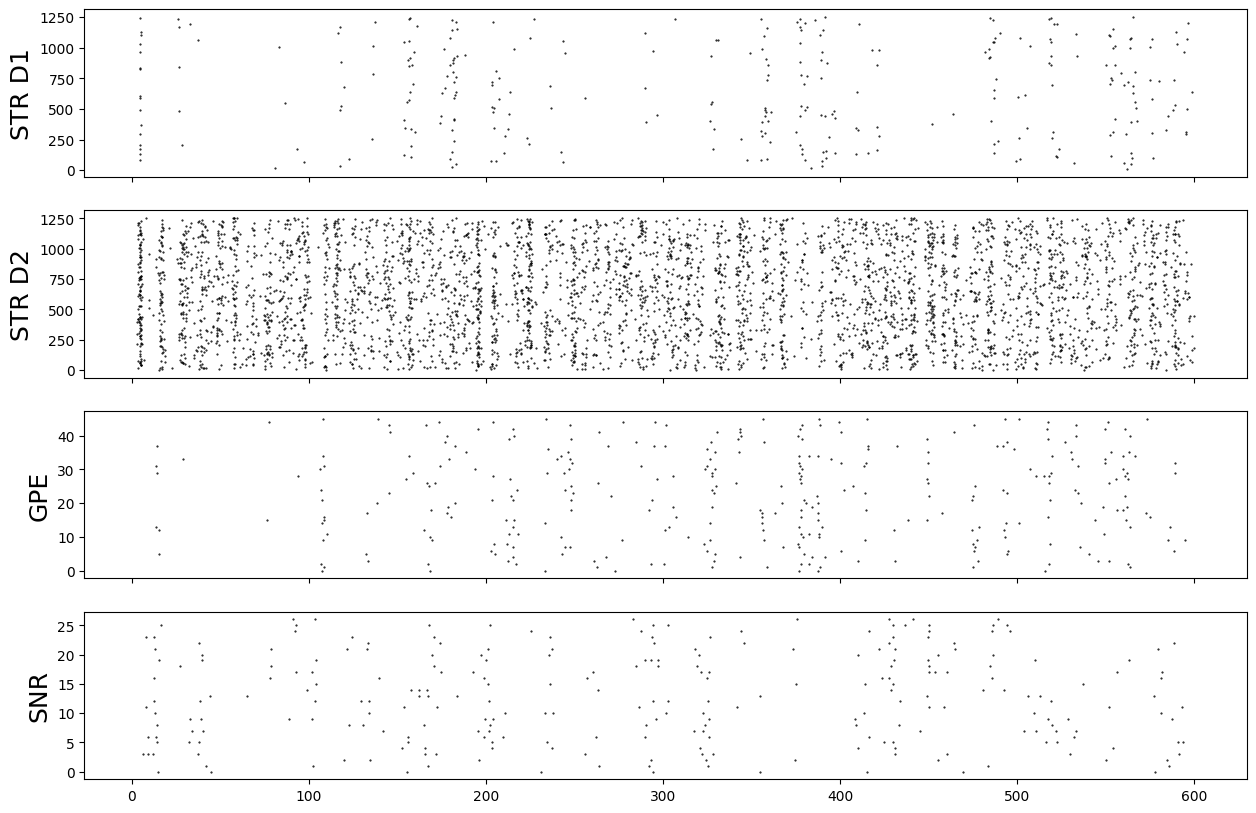

In [8]:
def raster_spikes(v_data, vth,dt):
    
    [T,N] = np.shape(v_data)
        
    t = []
    x = []
        
    for i in range(0,T):
        for j in range(0,N):
            
            if(v_data[i,j] >= vth):
                
                t.append( i*dt )
                x.append(j)
                
    return (x,t)


data_str1 = monitor_str1.get_data()
v_data_str1 = data_str1[list(data_str1.keys())[0]]["v"]
[x_str1,t_str1]  = raster_spikes(v_data_str1,30,dt)

data_str2 = monitor_str2.get_data()
v_data_str2 = data_str2[list(data_str2.keys())[0]]["v"]
[x_str2,t_str2]  = raster_spikes(v_data_str2,30,dt)

data2 = monitor2.get_data()
v_data2 = data2[list(data2.keys())[0]]["v"]
[x2,t2]  = raster_spikes(v_data2,30,dt)

data3 = monitor3.get_data()
v_data3 = data3[list(data3.keys())[0]]["v"]
[x3,t3]  = raster_spikes(v_data3,30,dt)
 
fig, ax = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
ax[0].plot(t_str1, x_str1, '.k',markersize=1)#ax[0,0].
ax[1].plot(t_str2, x_str2, '.k',markersize=1) 
ax[2].plot(t2, x2, '.k',markersize=1) 
ax[3].plot(t3, x3, '.k',markersize=1) 

 
ax[0].set_ylabel('STR D1', fontsize=18)
ax[1].set_ylabel('STR D2', fontsize=18)
ax[2].set_ylabel('GPE', fontsize=18)
ax[3].set_ylabel('SNR', fontsize=18)
plt.savefig("inhibition.svg")

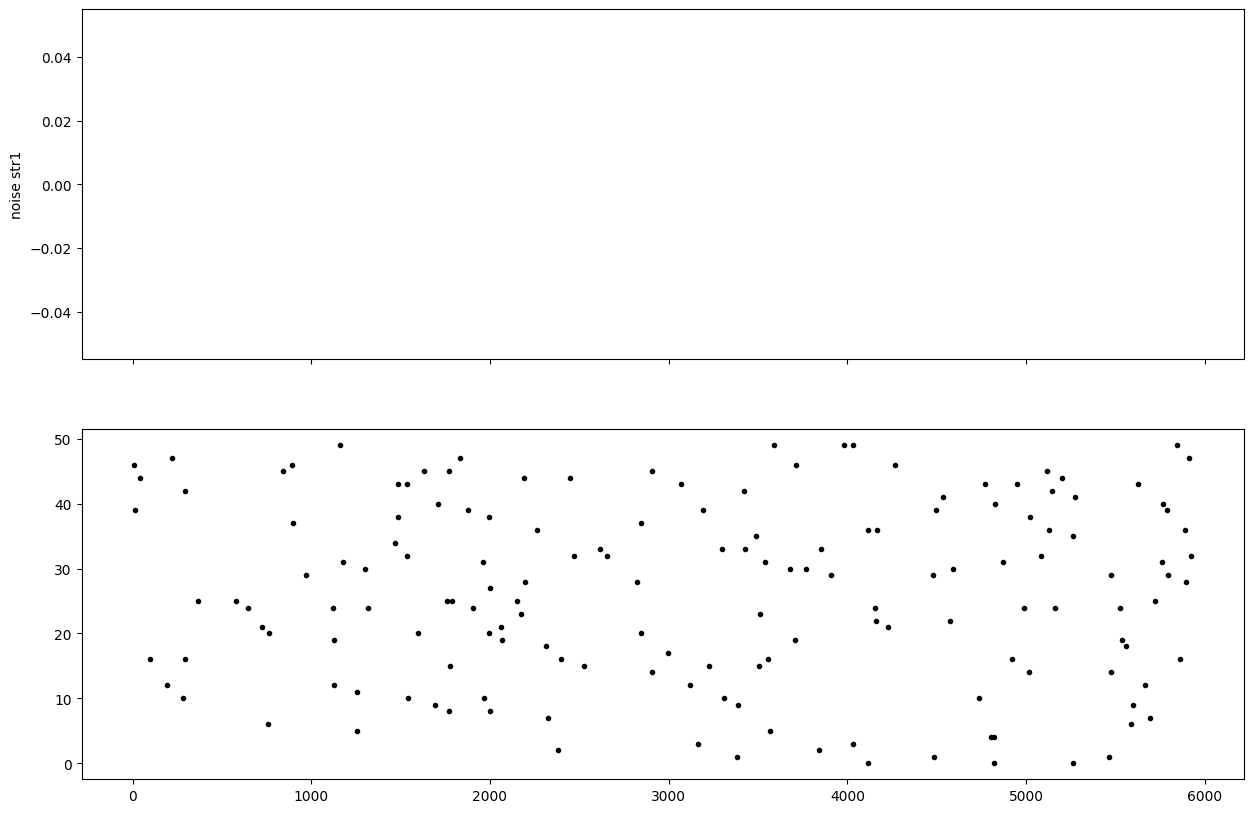

In [9]:
data4 = monitor4.get_data()
v_data4 = data4[list(data4.keys())[0]]["spike_data"]
[x4,t4]  = raster_spikes(v_data4,1,1)
 
data5 = monitor5.get_data()
v_data5 = data5[list(data5.keys())[0]]["spike_data"]
[x5,t5]  = raster_spikes(v_data5,1,1)

fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
ax[0].plot(t4, x4, '.k') 
ax[0].set_ylabel('noise str1')
ax[1].plot(t5, x5, '.k') 